# 作業工程計画
2022.12.12作成<br>
1. 受領データ（21、22夏）を結合
    参考：採点者品質予測_22秋後半納品_前処理_1025_v1.ipynb
2. 参加回数を修正
3. 欠損値を削除
4. 可視化

# ライブラリ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import re 

## 村上さん pandas_tool

In [2]:
"""
村上さんtoolbox
"""
# pandas 基礎集計クラス
import numpy as np
import pandas as pd
import copy
import seaborn as sns
from itertools import combinations

#http://qiita.com/tanemaki/items/2ed05e258ef4c9e6caac

# Jupyterで表示するためには、最初に以下を実行すること
%matplotlib inline

# Static Classで設計する
class pandas_tool:
    
    # All in one チェック（Jupyterのみ）
    def all_basic_summary_jupyter(df):
        print("■ 型の確認")
        display(pandas_tool.type(df))
        print("■ 数値型の確認")
        display(pandas_tool.summary(df)[0])
        print("■ カテゴリ型の確認")
        cate_var_data = list(df.select_dtypes(include=['object']).columns)
        ret = pandas_tool.freq(df,cate_var_data)
        for d in ret:
            display(pd.DataFrame(d))
            print("---------------")
        print("■ 欠損の確認")
        display(pandas_tool.check_missing(df))
    
    # 相関関係可視化（Jupyterのみ）
    def all_value_relation_visualize(df):
        #sns.set_context("poster", 1.2, {"lines.linewidth": 3})
        sns.pairplot(df,size=5)
    
    # カテゴリ変数でのヒートマップ（Jupyterのみ）
    def make_heatmap(df,x,y,value):
        target_df = df.pivot_table(index=x,values=value,columns=y)
        sns.heatmap(target_df, annot=True, fmt='1.1f', cmap='Blues')
    
    # 散布図（Jupyterのみ）
    def make_scatter_chart(df,x,y):
        #sns.jointplot(x=x, y=y, data=df, kind="hex")
        sns.jointplot(x=x, y=y, data=df)
    
    # 組み合わせでヒートマップを作成（Jupyterのみ）
    def all_make_heatmap(df,var_list,value):
        col_num = 2
        var_list_set = list(combinations(var_list,2))
        
        fig, axes = plt.subplots(int(len(var_list_set)/col_num)+1, col_num, figsize=(18,3+6.5*int(len(var_list_set)/col_num)))
        
        for i,target in enumerate(var_list_set):
            target_df = df.pivot_table(index=target[0],values=value,columns=target[1])
            sns.heatmap(target_df, annot=True, fmt='1.1f', cmap='Blues', ax=axes[int(i/col_num), i%col_num])
            
        plt.tight_layout()
    
    # 数値集計
    def summary(df,view=False):
        ret=df.describe()
        mis_ret=df.isnull().sum()
        if view:
            param=pd.get_option("display.max_columns")
            pd.set_option("display.max_columns",1000)
            print("・統計量")
            print(ret)
            print("・欠損値")
            print(mis_ret)
            pd.set_option("display.max_columns",param)
        return ret,mis_ret
    
    # 型チェック
    def type(df,view=False):
        ret = df.dtypes
        if view:
            param=pd.get_option("display.max_rows")
            pd.set_option("display.max_rows",1000)
            print(ret)
            pd.set_option("display.max_rows",param)
        return ret
    
    # 欠損チェック
    def check_missing(df,view=False):
        not_null_df=df.notnull()
        ret=pd.DataFrame()
        for name in not_null_df.columns:
            tmp_df=not_null_df[name].value_counts()
            tmp_df.name=name
            ret = pd.concat([ret,tmp_df],axis=1)
        
        if view:
            param=pd.get_option("display.max_columns")
            pd.set_option("display.max_columns",1000)
            print(ret)
            pd.set_option("display.max_columns",param)
        
        return ret
    
    # 欠損値のオブザベーションを抽出
    def get_miss_data(df,column,view=False):
        ret=df[df[column].isnull()]
        if view:
            param=pd.get_option("display.max_columns")
            pd.set_option("display.max_columns",1000)
            print(ret)
            pd.set_option("display.max_columns",param)
        return ret
    
    # 欠損値を中央値で補完
    def fill_miss_med(df,var_name):
        var=df[var_name].median()
        df[var_name].fillna(var,inplace=True)
        return df
    
    # 欠損値を0で補完
    def fill_miss_zero(df,var_name):
        df[var_name].fillna(0,inplace=True)
        return df
    
    # 特定の値を欠損とみなす
    def apply_miss_value(df,var_name,value):
        df[var_name]=df[var_name].replace(value,np.nan)
        return df
    
    # 重複チェック
    def check_dup(df,columns,view=False):
        ret=pd.DataFrame()
        for name in columns:
            dup_cnt=df[name].duplicated().sum()
            tmp_df = pd.DataFrame({'var_name':[name],'dup_cnt':[dup_cnt]})
            ret = pd.concat([ret,tmp_df],axis=0,ignore_index= True)
        
        if view:
            param=pd.get_option("display.max_columns")
            pd.set_option("display.max_columns",1000)
            print(ret)
            pd.set_option("display.max_columns",param)
        
        return ret
    
    # 組み合わせ重複チェック
    def check_dup_comb(df,columns,view=False):
        ret = df[columns].duplicated().sum()
        if view:
            param=pd.get_option("display.max_columns")
            pd.set_option("display.max_columns",1000)
            print(ret)
            pd.set_option("display.max_columns",param)
        
        return ret
    
    # ユニークデータ取得
    def get_uniq_data(df,uniq_key,sort_key,keep='first'):
        ret = df.sort_values(by=sort_key)
        ret.drop_duplicates(subset=uniq_key, keep=keep, inplace=True)
        return ret
    
    # カテゴリ集計
    def freq(df,columns,view=False):
        ret=list()
        for name in columns:
            tmp_df=df[name].value_counts()
            tmp_df.name=name
            #ret = pd.concat([ret,tmp_df],axis=1)
            ret.append(tmp_df)
        
        if view:
            param=pd.get_option("display.max_columns")
            pd.set_option("display.max_columns",1000)
            for r in ret:
                print(r)
                #display(r)
            pd.set_option("display.max_columns",param)
        
        return ret
    
    # 複雑な集計
    def tabulate(df,row,col=None,var='',func=np.sum,view=False):
        if var == '':
            tmp_df=df.reset_index(drop=False,inplace=False)
            ret=pd.pivot_table(data=tmp_df, values='index', index=row, columns=col, aggfunc='count', dropna=False, fill_value=0 ,margins = False)
            tmp_df=None
        else:
            ret=pd.pivot_table(data=df, values=var, index=row, columns=col, aggfunc=func, dropna=False, fill_value=0 ,margins = False)
        if view:
            param=pd.get_option("display.max_columns")
            pd.set_option("display.max_columns",1000)
            print(ret)
            pd.set_option("display.max_columns",param)
        
        return ret
    
    # マージ
    def merge(df1,df2,key,how,view=True):
        if view:
            print("df1のキー重複")
            pandas_tool.check_dup_comb(df1,key,True)
            print("df2のキー重複")
            pandas_tool.check_dup_comb(df2,key,True)
            
            print("df1のオブザベーション:{0}".format(len(df1)))
            print("df2のオブザベーション:{0}".format(len(df2)))
        
        ret=pd.merge(df1,df2,how=how,on=key)
        
        if view:
            print("mergeのオブザベーション:{0}".format(len(ret)))
        
        return ret
    
    # Rank
    def rank(df,var,num,suffix='_rank',check=False):
        labels=[i for i in range(0,num)]
        df[var+suffix]=pd.qcut(df[var], num, labels=labels)
        
        # check data
        if check:
            ret=pd.DataFrame()
            max_df=pandas_tool.tabulate(df=df,row=[var+suffix],var=var,func=np.max,view=False)
            max_df.name='max'
            min_df=pandas_tool.tabulate(df=df,row=[var+suffix],var=var,func=np.min,view=False)
            min_df.name='min'
            cnt_df=pandas_tool.tabulate(df=df,row=[var+suffix],var=var,func='count',view=False)
            cnt_df.name='count'
            ret=pd.concat([ret,min_df,max_df,cnt_df],axis=1)
            return df,ret
            
        return df
    
    # Rank適用(min基準)
    def apply_rank(df,rank_df):
        tmp_df=copy.deepcopy(rank_df)
        tmp_df.reset_index(drop=False,inplace=True)
        target_name=tmp_df.columns[3]
        tmp_df.columns=["rank","min","max","cnt"]
        
        def judge_thld(row):
            ret_var = -1
            cond_list = ["if 0 : ret_var = 0"]
            
            for i in range(1,len(tmp_df)):
                cond_list.append("elif row < " +str(tmp_df.ix[i,'min'])+ " : ret_var = " + str(tmp_df.ix[i-1,'rank']))
            
            cond_list.append("else: ret_var = " + str(tmp_df.ix[len(tmp_df)-1,'rank']))
            cond_str="\r\n".join(cond_list)
            # ローカル辞書をexecと共有する
            local_dict=locals()
            exec(cond_str,local_dict)
            return local_dict["ret_var"]
        
        df[target_name+"_rank"]=df[target_name].apply(judge_thld)
        return df
    
    # Min%以下はMin%点に、Max%以上はMax%点にクリップする
    def clip_min_max(df,col_list,apply_df=None,max_pct=0.99,min_pct=0.01):
        p_min = df[col_list].quantile(min_pct)
        p_max = df[col_list].quantile(max_pct)
        
        df[col] = df[col_list].clip(p_min,p_max,axis=1)
        
        # もしも適用先のデータがあるならば（例えば検証データ）対応
        if apply_df is not None:
            apply_df[col] = apply_df[col_list].clip(p_min,p_max,axis=1)
            return df,apply_df
        else:
            return df
    
    
    # 文字列→数値変換
    def conv_float(df,column,percent_flg=False):
        
        def conv_f(row):
            if row[column] == "" or row[column] is np.nan:
                return np.nan
            else:
                return float(row[column])
        
        df[column]=df[column].str.replace("\\","").str.replace(",","").str.replace("%","").str.strip()
        df[column]=df.apply(conv_f,axis=1)
        
        if percent_flg:
            df[column]=df[column]/100
        
        return df

# データの前処理

In [3]:
#過去データ読み込み 

path_folder = r"/Users/s.ogura/Documents/CRLEA/data/intermediatedata"#データが置いてあるフォルダパス

# csvファイルの読み込みと空のリストに追加
name_csv = "採点者情報0720+0818_pretreated_v2_jpn.csv" #ファイル名
path_file = r'{p}/{n}'.format(p = path_folder, n = name_csv)#ファイルパスとファイル名
df_jpn = pd.read_csv(filepath_or_buffer = path_file, sep=",")

# csvファイルの読み込みと空のリストに追加
name_csv = "採点者情報0720+0818_pretreated_v2_math.csv" #ファイル名
path_file = r'{p}/{n}'.format(p = path_folder, n = name_csv)#ファイルパスとファイル名
df_math = pd.read_csv(filepath_or_buffer = path_file, sep=",")

# csvファイルの読み込みと空のリストに追加
name_csv = "採点者情報0720+0818_pretreated_v2_eng.csv" #ファイル名
path_file = r'{p}/{n}'.format(p = path_folder, n = name_csv)#ファイルパスとファイル名
df_eng = pd.read_csv(filepath_or_buffer = path_file, sep=",")

/Users/s.ogura/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [33]:
df_jpn.columns.values

array(['スタッフコード', 'スタッフコード3', '年度', '採点回', '科目コード', '身分', '性別', '年齢',
       '登録試験点数', '大学', '学部', '偏差値', '参加回数', '等級', '学年', '割当', '分野名',
       '最終ペース', '採否時登録時間', '1回目採点満点', '1回目採点得点', '完全混在枚数総数', '完全一致枚数',
       '完全一致率', '範囲内混在枚数総数', '範囲内一致枚数', '範囲内一致率', '最終シール', 'ACTB',
       'ACTB理由', 'ACTB登録日', '依頼枚数', '枠更新率', '科目', '分野', 'ポイント採点', '文字数',
       'ポイント数', '配点要素の数', '配点', '必須条件の有無', '企画ペース', '最終ペース_設問'],
      dtype=object)

In [34]:
df_math.columns.values

array(['スタッフコード', 'スタッフコード3', '年度', '採点回', '科目コード', '身分', '性別', '年齢',
       '登録試験点数', '大学', '学部', '偏差値', '参加回数', '等級', '学年', '割当', '分野名_x',
       '最終ペース', '採否時登録時間', '1回目採点満点', '1回目採点得点', '完全混在枚数総数', '完全一致枚数',
       '完全一致率', '範囲内混在枚数総数', '範囲内一致枚数', '範囲内一致率', '最終シール', 'ACTB',
       'ACTB理由', 'ACTB登録日', '依頼枚数', '枠更新率', '科目', '分野名_y', '（1）実点・立式点',
       '（1）カッコ点・立式点', '（1）実点・答え点', '（1）カッコ点・答え点', '（1）実点・その他',
       '（1）カッコ点・その他', '（2）実点・立式点', '（2）カッコ点・立式点', '（2）実点・答え点',
       '（2）カッコ点・答え点', '（2）実点・その他', '（2）カッコ点・その他', '（3）実点・立式点',
       '（3）カッコ点・立式点', '（3）実点・答え点', '（3）カッコ点・答え点', '（3）実点・その他',
       '（3）カッコ点・その他', '（1）ポイント数合計', '（2）ポイント数合計', '（3）ポイント数合計', 'ポイント採点',
       '（1）配点', '（2）配点', '（3）配点', '企画ペース', '最終ペース_設問', '模範解答の記述行数（１）',
       '模範解答の記述行数（２）', '模範解答の記述行数（３）', '補足資料の枚数', '分野'], dtype=object)

In [35]:
df_eng.columns.values

array(['スタッフコード', 'スタッフコード3', '年度', '採点回', '科目コード', '身分', '性別', '年齢',
       '登録試験点数', '大学', '学部', '偏差値', '参加回数', '等級', '学年', '割当', '分野名',
       '最終ペース', '採否時登録時間', '1回目採点満点', '1回目採点得点', '完全混在枚数総数', '完全一致枚数',
       '完全一致率', '範囲内混在枚数総数', '範囲内一致枚数', '範囲内一致率', '最終シール', 'ACTB',
       'ACTB理由', 'ACTB登録日', '依頼枚数', '枠更新率', '科目', '大問', '分野', '解答言語',
       'ポイント採点', '企画ペース', '最終ペース_設問', 'パターン数', '配点合計', '文字数合計', 'ポイント数合計',
       '減点要素の数合計'], dtype=object)

In [36]:
#設問情報を加えない、全科目の結合df
collist=['スタッフコード', '年度', '採点回','学年', '科目','分野','割当', '身分', '年齢','大学',
       '学部', '登録試験点数','採否時登録時間','依頼枚数', '参加回数', '等級','最終シール',  '完全一致率','偏差値','枠更新率']
df1=df_jpn[collist]
df2=df_math[collist]
df3=df_eng[collist]
df_all =[]
df_all = df1.append(df2)
df_all = df_all.append(df3)

#等級を除外するなどの処理を行う関数を実行
def rem_tokyu(df_input):
    df = df_input.copy()
    #等級を選別する。
    colname='等級'
    df[colname] = df[colname].astype(str)
    df = df[df[colname].isin(["1","2",'01','02'])]
    #等級の列を除外する
    df = df.drop(columns = colname)
    return df
df_all = rem_tokyu(df_all)

In [38]:
df_all.columns.values

array(['スタッフコード', '年度', '採点回', '学年', '科目', '分野', '割当', '身分', '年齢', '大学',
       '学部', '登録試験点数', '採否時登録時間', '依頼枚数', '参加回数', '最終シール', '完全一致率', '偏差値',
       '枠更新率'], dtype=object)

In [37]:
#偏差値更新

path_name = "/Users/s.ogura/Documents/CRLEA/data/rawdata/CRLEA採点者情報入力様式_v1.1_大学追加_秋後半.xlsx"
path_file =  r'{}'.format(path_name)
input_file = pd.ExcelFile(path_file)
sn_list = input_file.sheet_names

df = []
df = pd.read_excel(path_file, sn_list[1], header=0, index_col=None,skiprows=None,usecols=['大学', '学部', '偏差値'])#headerを修正
df = df.rename(columns = {'過去参加回数':'参加回数'})
df_hensa = df.copy()

In [40]:
#分野情報を割り当て、採点回、年度をキーにして結合する
df1 = df_all
df2 = df_hensa
df = pandas_tool.merge(df1,df2, key = ['大学', '学部'],how = 'left')
df['偏差値_y'] = df['偏差値_y'].fillna(df['偏差値_x'], inplace=False)
df = df.rename(columns = {'偏差値_y':'偏差値'})
colname='偏差値'
df[colname] = df[colname].replace({'-':np.nan,
                                    '空白':np.nan,
                                    '短大':np.nan,
                                    '不明':np.nan,
                                    "大学不明":np.nan,
                                    '専門':np.nan,
                                    'なし':np.nan,
                                    '該当なし':np.nan})
df[colname] = df[colname].astype(float)
df = df.drop(['偏差値_x'], axis=1)
df_all2 = df.copy()

df1のキー重複
20317
df2のキー重複
104
df1のオブザベーション:22296
df2のオブザベーション:2837
mergeのオブザベーション:22738


In [149]:
"""
表記揺れや異常値の削除などのデータ前処理
"""

#枠更新率の異常値を削除
df = df_all2
colname='枠更新率'
df[colname] = df[colname].replace({'-':np.nan,
                                    '不参加':np.nan})
df = df.dropna(subset=[colname])
df[colname] = df[colname].astype(float)
#科目の表記揺れ直し
colname='科目'
df[colname] = df[colname].replace({'数学X/A\u3000':'数学X/A'})
df = df.dropna(subset=[colname])

#科目の表記揺れ直し
colname='登録試験点数'
df[colname] = df[colname].replace({999:np.nan,
                                  0:np.nan})
df = df.dropna(subset=[colname])

#完全一致率の異常値削除
colname='完全一致率'
df[colname] = df[colname].replace({'-':np.nan,
                                   'NG':np.nan,
                                  0:np.nan})
df = df.dropna(subset=[colname])
df[colname] = df[colname].astype(float)

#身分の空欄削除
colname='身分'
df = df.dropna(subset=[colname])

#データ型の変換
colname='採否時登録時間'
df[colname] = df[colname].astype(float)
colname='依頼枚数'
df[colname] = df[colname].astype(float)

df_all3 = df

/var/folders/ll/_gcfyf2137x3x6dwgb9nkj740000gp/T/ipykernel_70136/3163720792.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[colname] = df[colname].astype(float)
/var/folders/ll/_gcfyf2137x3x6dwgb9nkj740000gp/T/ipykernel_70136/3163720792.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[colname] = df[colname].replace({'数学X/A\u3000':'数学X/A'})


In [150]:
df_all3.columns.values

array(['スタッフコード', '年度', '採点回', '学年', '科目', '分野', '割当', '身分', '年齢', '大学',
       '学部', '登録試験点数', '採否時登録時間', '依頼枚数', '参加回数', '最終シール', '完全一致率',
       '枠更新率', '偏差値'], dtype=object)

In [79]:
#ヒストグラム
df = df_all3
collist=['年齢','登録試験点数','採否時登録時間','依頼枚数', '参加回数','偏差値','枠更新率']
df=df[collist]

In [97]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10#サイズ変更

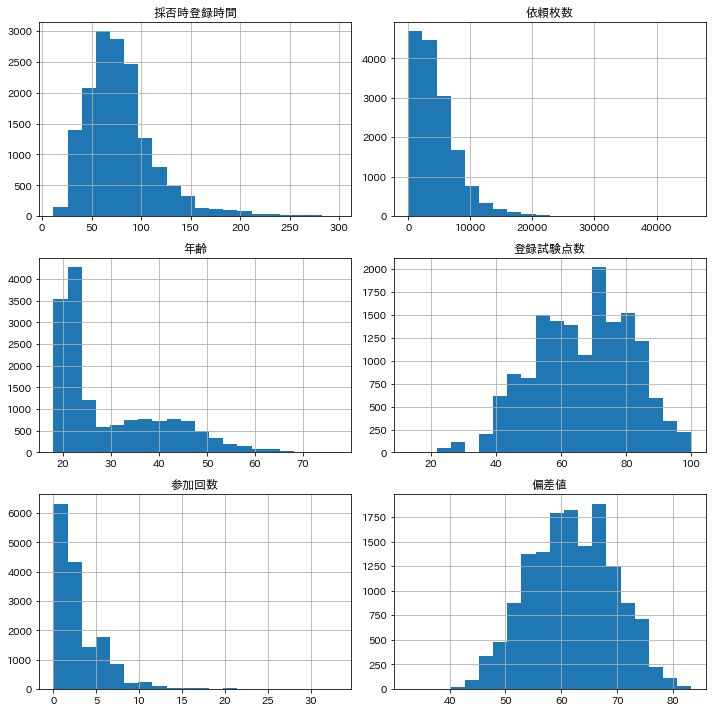

In [98]:
df[['採否時登録時間','依頼枚数','年齢','登録試験点数', '参加回数','偏差値']].hist(bins=20)
plt.tight_layout() # グラフ同士が重ならないようにする関数
plt.show() # グラフの表示

In [182]:
#ランク作成

# 年齢
#'登録試験点数', 
# '採否時登録時間',
# '依頼枚数',
# '参加回数', 
# '偏差値',

def make_rank_waku(df_input):
    df = df_input.copy()
    
    x = "参加回数"
    conditions = [
        (df[x] >= 6),
        (df[x] >= 5),
        (df[x] >= 4),
        (df[x] >= 3),
        (df[x] >= 2),
        (df[x] >= 1)
    ]    
    choices = ["6~", "5", "4", "3", "2", "1"]
    df.loc[:,'参加回数ランク'] = np.select(conditions, choices, default = 0)
    
    x = "登録試験点数"
    conditions = [
        (df[x] >= 90),
        (df[x] >= 80),
        (df[x] >= 70),
        (df[x] >= 60),
        (df[x] >= 50)
         ]   
    choices = ["90~100", "80~89", "70~79", "60~69", "50~59"]
    df.loc[:,'登録試験点数ランク'] = np.select(conditions, choices, default = "0~49")
    
    x = "偏差値"
    conditions = [
        (df[x] >= 70),
        (df[x] >= 65),
        (df[x] >= 60),
        (df[x] >= 55),
        (df[x] >= 50)
         ]    
    choices = ["70~", "65~70", "60~65", "55~60", "50~55"]
    df.loc[:,'偏差値ランク'] = np.select(conditions, choices, default = "0~49")
    
    x = "年齢"
    conditions = [
        (df[x] >= 60),
        (df[x] >= 50),
        (df[x] >= 40),
        (df[x] >= 30),
        (df[x] >= 25),
        (df[x] >= 22),
        (df[x] >= 18)
         ]    
    choices = ["60~", "50~59", "40~49", "30~39", "25~29", "22~24", "18~21"]
    df.loc[:,'年齢ランク'] = np.select(conditions, choices, default = "0~18")

    x = "依頼枚数"
    conditions = [
        (df[x] >= 10000),
        (df[x] >= 8000),
        (df[x] >= 6000),
        (df[x] >= 4000),
        (df[x] >= 2000)
         ]    
    choices = ["9999~", "8000~9999", "6000~7999", "4000~5999", "2000~3999"]
    df.loc[:,'依頼枚数ランク'] = np.select(conditions, choices, default = "0~1999")
    
    x = "採否時登録時間"
    conditions = [
        (df[x] >= 150),
        (df[x] >= 100),
        (df[x] >= 70),
        (df[x] >= 50)
         ]    
    choices = ["150~", "100~149", "070~100", "050~70"]
    df.loc[:,'登録時間ランク'] = np.select(conditions, choices, default = "000~49")    
    
    x = "完全一致率"
    conditions = [
        (df[x] >= 0.95),
        (df[x] >= 0.9),
        (df[x] >= 0.85),
        (df[x] >= 0.8),
        (df[x] >= 0.75),
        (df[x] >= 0.7)
         ]    
    choices = ["0.95~", "0.90~0.95", "0.85~0.90", "0.80~0.85", "0.75~0.80", "0.70~0.75"]
    df.loc[:,'完全一致率ランク'] = np.select(conditions, choices, default = "0.0~0.7")
    
    x = "枠更新率"
    conditions = [
        (df[x] >= 0.99),
        (df[x] >= 0.98),
        (df[x] >= 0.97),
        (df[x] >= 0.96),
        (df[x] >= 0.95),
        (df[x] >= 0.94),
        (df[x] >= 0.93),
        (df[x] >= 0.92),
        (df[x] >= 0.91),
        (df[x] >= 0.9),
        (df[x] >= 0.85),
        (df[x] >= 0.8),
        (df[x] >= 0.75),
        (df[x] >= 0.7)
         ]    
    choices = ["0.99~1", "0.98~0.99","0.97~0.98","0.96~0.97","0.95~0.96","0.94~0.95","0.93~0.94","0.92~0.93","0.91~0.92","0.90~0.91",
               "0.85~0.90", "0.80~0.85", "0.75~0.80", "0.70~0.75"]
    df.loc[:,'枠更新率ランク'] = np.select(conditions, choices, default = "0.0~0.7")
    return df

In [183]:
df_all4 = make_rank_waku(df_all3)

In [184]:
"""
表記揺れや異常値の削除などのデータ前処理
"""

#枠更新率の異常値を削除
df = df_all4
colname='枠更新率'
df[colname] = df[colname].replace({'-':np.nan,
                                    '不参加':np.nan,
                                  0:np.nan})
df = df.dropna(subset=[colname])
df[colname] = df[colname].astype(float)

df_all4_0 = df

In [185]:
"""
Excelの書き出し 
"""
df1 = df_all4
df2 = df_all4_0

name = "枠更新率分析DM_21年と22夏_v4.1"
path_folder = r"/Users/s.ogura/Documents/CRLEA/data/intermediatedata"#フォルダパス

#Excel
with pd.ExcelWriter('{}/{}.xlsx'.format(path_folder,name)) as writer:
    df1.to_excel(writer, sheet_name='枠更新率0含む',encoding='utf-8-sig', index = False)
    df2.to_excel(writer, sheet_name='枠更新率0除外',encoding='utf-8-sig', index = False)

In [186]:
"""
csvの書き出し
"""
df = df_all4

name = "枠更新率分析DM_v4.1"
path_folder = r"/Users/s.ogura/Documents/CRLEA/data/intermediatedata"#フォルダパス

#csv
df.to_csv('{}/{}.csv'.format(path_folder,"{}".format(name)),encoding='utf-8-sig',index=False)

"""
csvの書き出し
"""
df = df_all4_0

name = "枠更新率分析DM_枠更新率0除外_v4.1"
path_folder = r"/Users/s.ogura/Documents/CRLEA/data/intermediatedata"#フォルダパス

#csv
df.to_csv('{}/{}.csv'.format(path_folder,"{}".format(name)),encoding='utf-8-sig',index=False)

# 集計

In [188]:
def check_cor(df_input, var1=str, var2=str):
    df = df_input
    s1 = df[var1]
    s2 = df[var2]
    res = s1.corr(s2)
    return res

In [193]:
collist=['年齢','登録試験点数', '採否時登録時間', '依頼枚数', '参加回数','完全一致率', '偏差値']
for i, name in enumerate(collist):
    # res = []
    # res[i]=check_cor(df_all4_0,'枠更新率',name)
    print(name, check_cor(df_all4_0,'枠更新率',name))

年齢 0.012895790679673986
登録試験点数 0.02394467590159981
採否時登録時間 -0.048342505941146606
依頼枚数 0.015158560680508746
参加回数 0.03936059460453197
完全一致率 0.11429041346439149
偏差値 0.022351922952949296


In [189]:
check_cor(df_all4_0,'枠更新率','偏差値')

0.022351922952949296

In [189]:
check_cor(df_all4_0,'枠更新率','偏差値')

0.022351922952949296

In [187]:
df = df_all4_0

s1=df['枠更新率']
s2=df['偏差値']

res=s1.corr(s2)   

# 結果
print(res)

0.022351922952949296


0.23385611715924406

In [64]:
def basic_stat(category = str):
    df = df_all3
    grouped = df.groupby(category)
    df_res = grouped.describe()['枠更新率'].reset_index()
    return df_res

In [65]:
df_kamoku = basic_stat('科目')
df_bunya = basic_stat('分野')
df_nendo = basic_stat('年度')
df_saitenkai= basic_stat('採点回')
df_mibun = basic_stat('身分')
df_kaisu = basic_stat('参加回数')

In [66]:
"""
Excelの書き出し 
"""

name = "枠更新率分析_v1"
path_folder = r"/Users/s.ogura/Documents/CRLEA/data/output"#フォルダパス

#Excel
with pd.ExcelWriter('{}/{}.xlsx'.format(path_folder,name)) as writer:
    df_kamoku.to_excel(writer, sheet_name='科目',encoding='utf-8-sig', index = False)
    df_bunya.to_excel(writer, sheet_name='分野',encoding='utf-8-sig', index = False)
    df_nendo.to_excel(writer, sheet_name='年度',encoding='utf-8-sig', index = False)
    df_saitenkai.to_excel(writer, sheet_name='採点回',encoding='utf-8-sig', index = False)
    df_mibun.to_excel(writer, sheet_name='身分',encoding='utf-8-sig', index = False)
    df_kaisu.to_excel(writer, sheet_name='参加回数',encoding='utf-8-sig', index = False)

In [62]:
#groupbyでカテゴリごとの基礎統計量を出す
df = df_all3
grouped = df.groupby('科目')
df_kamoku = grouped.describe()['枠更新率'].reset_index()

grouped = df.groupby('分野')
df_bunya = grouped.describe()['枠更新率'].reset_index()

grouped = df.groupby('参加回数')
df_sanka = grouped.describe()['枠更新率'].reset_index()

grouped = df.groupby('分野')
df_bunya = grouped.describe()['枠更新率'].reset_index()

In [21]:
from pivottablejs import pivot_ui

In [169]:
pivot_ui(df_all4_0)